<a href="https://colab.research.google.com/github/stepsbtw/Integer-Linear-Programming/blob/main/Iniciacao_Cientifica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading TSP and Plotting

In [15]:
import numpy as np
def read_tsplib(filename):
    coords = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        node_section = False
        for line in lines:
            if "NODE_COORD_SECTION" in line:
                node_section = True
                continue
            if node_section:
                if "EOF" in line:
                    break
                parts = line.strip().split()
                if len(parts) == 3:
                    coords.append((float(parts[1]), float(parts[2])))
    return np.array(coords)

In [16]:
!pip install tsplib95

In [17]:
import tsplib95

berlin52 = tsplib95.load('/content/drive/MyDrive/TSPLIB/berlin52/berlin52.tsp')
a280 = tsplib95.load('/content/drive/MyDrive/TSPLIB/a280/a280.tsp')
brazil58 = tsplib95.load('/content/drive/MyDrive/TSPLIB/brazil58/brazil58.tsp')
dantzig52 = tsplib95.load('/content/drive/MyDrive/TSPLIB/dantzig42/dantzig42.tsp')

def return_coords(problem):
  nodes = list(problem.get_nodes())
  coords = [problem.node_coords[i] for i in nodes]
  return np.array(coords)

In [18]:
def compute_distance_matrix(coords):
    n = len(coords)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i][j] = np.linalg.norm(np.array(coords[i]) - np.array(coords[j]))
    return dist_matrix

In [19]:
def route_distance(route, coords):
    return sum(np.linalg.norm(coords[route[i]] - coords[route[(i+1) % len(route)]]) for i in range(len(route)))

In [20]:
import matplotlib.pyplot as plt

def plot_tsp(coords, tour=None, title="Instância TSP"):
    plt.figure(figsize=(8, 6))
    plt.scatter(coords[:, 0], coords[:, 1], c='blue')
    for i, (x, y) in enumerate(coords):
        plt.text(x + 0.1, y + 0.1, str(i), fontsize=9)
    if tour is not None:
        ordered_coords = coords[tour + [tour[0]]]
        plt.plot(ordered_coords[:, 0], ordered_coords[:, 1], 'r-')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()
    if tour is not None:
      print(route_distance(tour, coords))

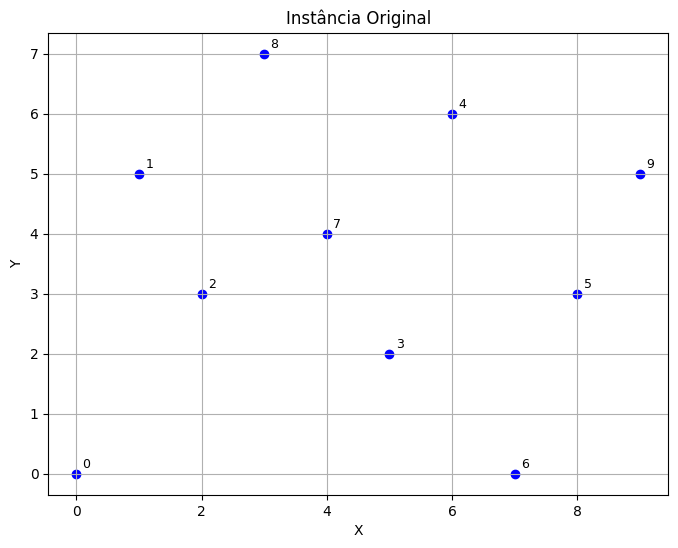

In [21]:
coords = np.array([
    [0, 0], [1, 5], [2, 3], [5, 2], [6, 6],
    [8, 3], [7, 0], [4, 4], [3, 7], [9, 5]
])

dist_matrix = compute_distance_matrix(coords)

plot_tsp(coords, title="Instância Original")

# Heurísticas Construtivas

## Nearest Neighbor

In [22]:
def nearest_neighbor(dist_matrix, start=0):
    n = len(dist_matrix)
    visited = [False] * n
    tour = [start]
    visited[start] = True

    for _ in range(n - 1):
        last = tour[-1]
        next_city = np.argmin([dist_matrix[last][j] if not visited[j] else np.inf for j in range(n)])
        tour.append(next_city)
        visited[next_city] = True

    tour.append(start)  # return to start
    return tour

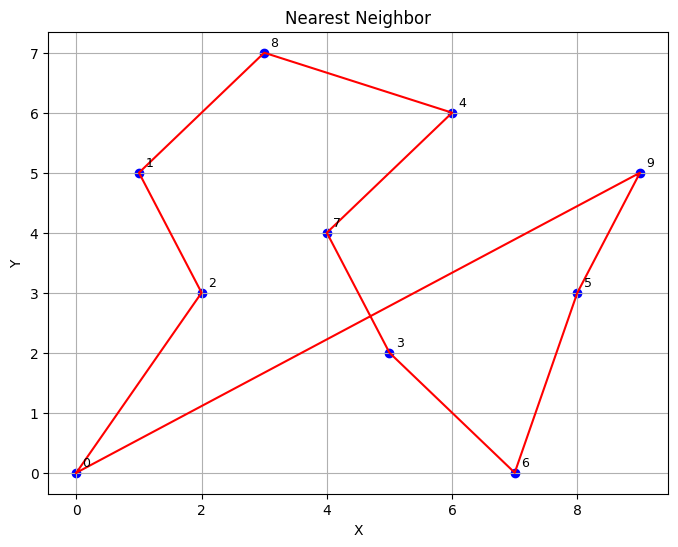

35.41922204352569


In [23]:
nn_route = nearest_neighbor(dist_matrix)
plot_tsp(coords, nn_route, title="Nearest Neighbor")

## Minimun Spanning Tree

In [24]:
def dfs_preorder(adj, u, visited, tour):
  visited[u] = True
  tour.append(u)
  for v in adj[u]:
      if not visited[v]:
          dfs_preorder(adj, v, visited, tour)

def prim_mst(dist_matrix):
    n = len(dist_matrix)
    selected = [False] * n
    selected[0] = True
    edges = []

    for _ in range(n - 1):
        min_edge = (None, None, float('inf'))
        for u in range(n):
            if selected[u]:
                for v in range(n):
                    if not selected[v] and dist_matrix[u][v] < min_edge[2]:
                        min_edge = (u, v, dist_matrix[u][v])
        u, v, _ = min_edge
        edges.append((u, v))
        selected[v] = True

    return edges

In [25]:
def mst_prim_tour(dist_matrix):
    n = len(dist_matrix)
    edges = prim_mst(dist_matrix)
    adj = [[] for _ in range(n)]

    for u, v in edges:
      adj[u].append(v)
      adj[v].append(u)

    # preorder DFS
    tour = []
    visited = [False]*n

    dfs_preorder(adj, 0, visited, tour)
    tour.append(tour[0])
    return tour

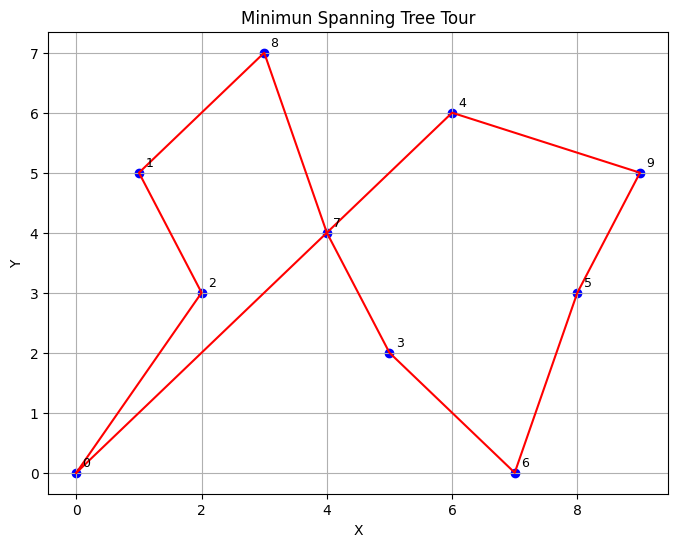

33.942723812199446


In [26]:
mst_route = mst_prim_tour(dist_matrix)
plot_tsp(coords, mst_route, title="Minimun Spanning Tree Tour")

## Christofides Algorithm

In [27]:
def minimum_weight_matching(odd_vertices, dist_matrix):
  min_matching = []
  used = set()
  for u in odd_vertices:
      if u in used: continue
      min_dist = float('inf')
      closest = None
      for v in odd_vertices:
          if v != u and v not in used and dist_matrix[u][v] < min_dist:
              min_dist = dist_matrix[u][v]
              closest = v
      min_matching.append((u, closest))
      used.add(u)
      used.add(closest)
  return min_matching

def christofides_tour(dist_matrix):
  n = len(dist_matrix)
  mst = prim_mst(dist_matrix)
  degree = [0] * n
  for u, v in mst:
    degree[u] += 1
    degree[v] += 1
  odd_vertices = [i for i in range(n) if degree[i] % 2 == 1]
  matching = minimum_weight_matching(odd_vertices, dist_matrix)

  multigraph = [[] for _ in range(n)]
  for u, v in mst + matching:
    multigraph[u].append(v)
    multigraph[v].append(u)

  # Hierholzer's algorithm for Eulerian tour
  stack = [0]
  path = []
  used_edges = set()
  while stack:
    u = stack[-1]
    for v in multigraph[u]:
      if (u, v) not in used_edges and (v, u) not in used_edges:
        used_edges.add((u, v))
        multigraph[u].remove(v)
        multigraph[v].remove(u)
        stack.append(v)
        break
    else:
        path.append(stack.pop())

  # Shortcut to form Hamiltonian cycle
  seen = set()
  tour = []
  for v in reversed(path):
      if v not in seen:
          seen.add(v)
          tour.append(v)
  tour.append(tour[0])
  return tour

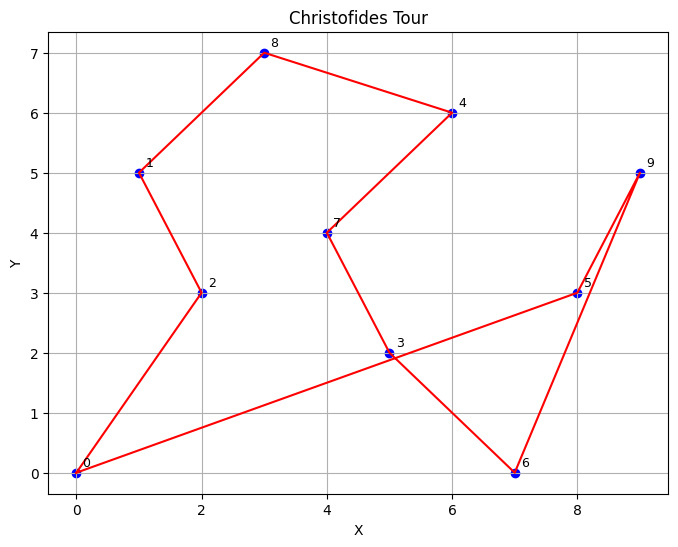

35.89048279482235


In [28]:
christofides_route = christofides_tour(dist_matrix)
plot_tsp(coords, christofides_route, title="Christofides Tour")

# Local Search Heuristics

## 2-opt and 3-opt

In [29]:
import numpy as np

def two_opt(route, coords):
    def dist(a, b):
        return np.linalg.norm(coords[a] - coords[b])

    def total_distance(route):
        return sum(dist(route[i], route[(i + 1) % len(route)]) for i in range(len(route)))

    improved = True
    iteration = 0
    current_distance = total_distance(route)
    print(f"Iteração {iteration}: distância inicial = {current_distance:.2f}")

    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                if j - i == 1:  # Evita trocar nós consecutivos
                    continue
                new_route = route[:i] + route[i:j][::-1] + route[j:]
                new_distance = total_distance(new_route)
                if new_distance < current_distance:
                    route = new_route
                    current_distance = new_distance
                    iteration += 1
                    print(f"Iteração {iteration}: nova distância = {current_distance:.2f}")
                    improved = True
                    break
            if improved:
                break
    return route

import numpy as np

def three_opt(route, coords):
    def dist(a, b):
        return np.linalg.norm(coords[a] - coords[b])

    def total_distance(route):
        return sum(dist(route[i], route[(i + 1) % len(route)]) for i in range(len(route)))

    improved = True
    iteration = 0
    current_distance = total_distance(route)
    print(f"Iteração {iteration}: distância inicial = {current_distance:.2f}")

    while improved:
        improved = False
        for i in range(len(route) - 5):
            for j in range(i + 2, len(route) - 3):
                for k in range(j + 2, len(route) - 1):
                    a, b = route[i], route[i + 1]
                    c, d = route[j], route[j + 1]
                    e, f = route[k], route[k + 1]

                    # Geração das 7 possibilidades
                    segments = [
                        route[:i+1] + route[i+1:j+1][::-1] + route[j+1:k+1] + route[k+1:],  # Case 1
                        route[:i+1] + route[i+1:j+1] + route[j+1:k+1][::-1] + route[k+1:],  # Case 2
                        route[:i+1] + route[j+1:k+1] + route[i+1:j+1] + route[k+1:],        # Case 3
                        route[:i+1] + route[j+1:k+1][::-1] + route[i+1:j+1] + route[k+1:],  # Case 4
                        route[:i+1] + route[j+1:k+1] + route[i+1:j+1][::-1] + route[k+1:],  # Case 5
                        route[:i+1] + route[i+1:j+1][::-1] + route[j+1:k+1][::-1] + route[k+1:],  # Case 6
                        route[:i+1] + route[j+1:k+1][::-1] + route[i+1:j+1][::-1] + route[k+1:]   # Case 7
                    ]

                    for new_route in segments:
                        new_distance = total_distance(new_route)
                        if new_distance + 1e-6 < current_distance:  # pequena tolerância
                            route = new_route
                            current_distance = new_distance
                            iteration += 1
                            print(f"Iteração {iteration}: nova distância = {current_distance:.2f}")
                            improved = True
                            break
                    if improved:
                        break
                if improved:
                    break
            if improved:
                break
    return route


Iteração 0: distância inicial = 35.42
Iteração 1: nova distância = 35.27
Iteração 2: nova distância = 34.01
Iteração 3: nova distância = 34.01
Iteração 4: nova distância = 33.37
Iteração 5: nova distância = 33.37
Iteração 6: nova distância = 31.43


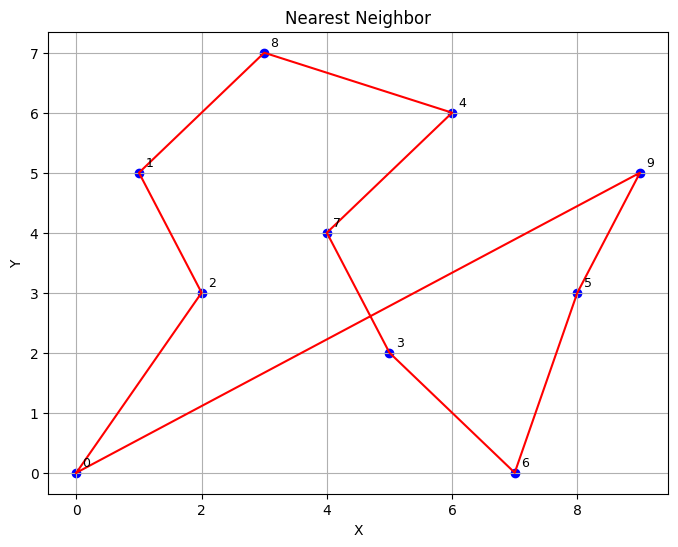

35.41922204352569
Iteração 0: distância inicial = 33.94
Iteração 1: nova distância = 33.32
Iteração 2: nova distância = 32.08
Iteração 3: nova distância = 32.08
Iteração 4: nova distância = 31.43


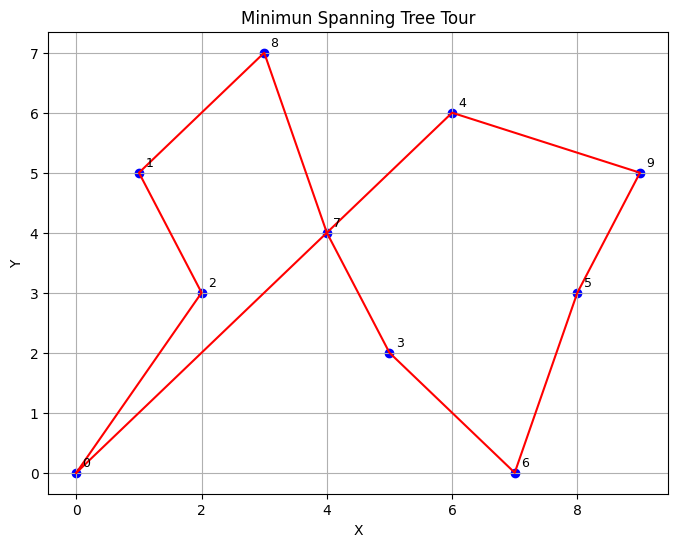

33.942723812199446
Iteração 0: distância inicial = 35.89
Iteração 1: nova distância = 35.89
Iteração 2: nova distância = 35.42
Iteração 3: nova distância = 34.30
Iteração 4: nova distância = 34.30


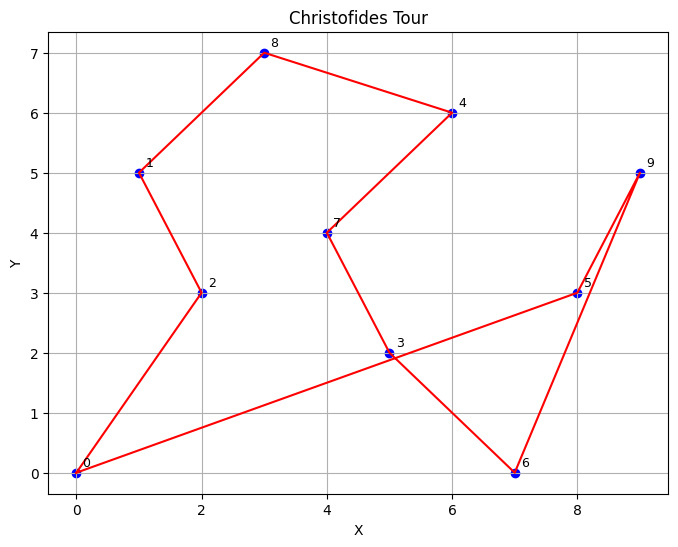

35.89048279482235


In [30]:
nn_route_two = two_opt(nn_route[:], coords)
plot_tsp(coords, nn_route, title="Nearest Neighbor")

mst_tour_two = two_opt(mst_route[:], coords)
plot_tsp(coords, mst_route, title="Minimun Spanning Tree Tour")

chris_tour_two = two_opt(christofides_route[:], coords)
plot_tsp(coords, christofides_route, title="Christofides Tour")

Iteração 0: distância inicial = 35.42
Iteração 1: nova distância = 31.11
Iteração 2: nova distância = 30.56


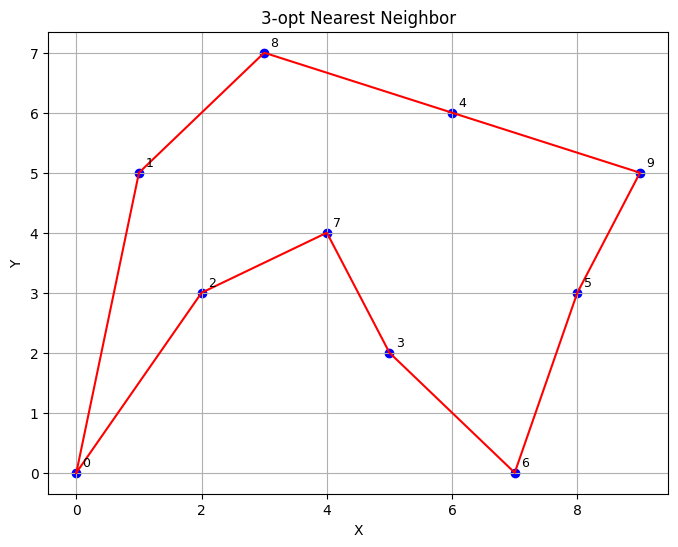

30.556461951553665
Iteração 0: distância inicial = 33.94
Iteração 1: nova distância = 31.11
Iteração 2: nova distância = 30.56


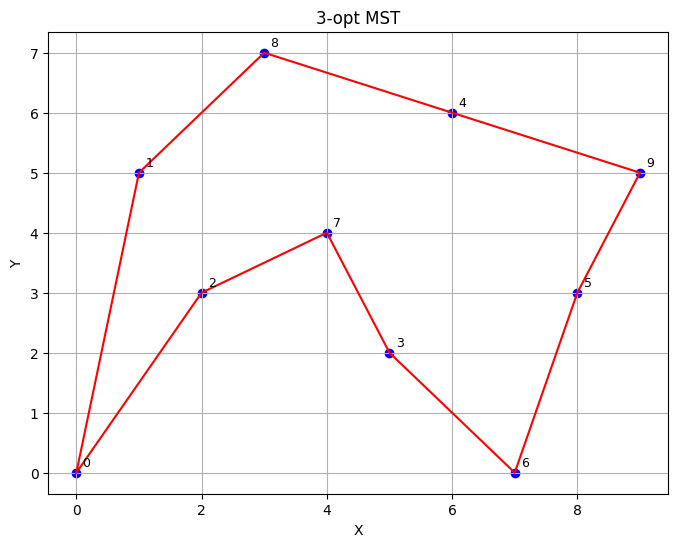

30.556461951553665
Iteração 0: distância inicial = 35.89
Iteração 1: nova distância = 33.78
Iteração 2: nova distância = 31.11
Iteração 3: nova distância = 30.56


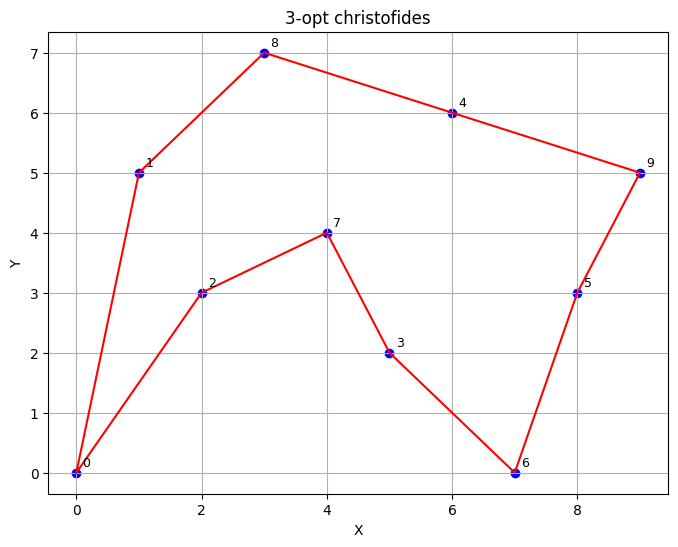

30.556461951553665


In [31]:
nn_route_three = three_opt(nn_route[:], coords)
plot_tsp(coords, nn_route_three, title="3-opt Nearest Neighbor")

mst_route_three = three_opt(mst_route[:], coords)
plot_tsp(coords, mst_route_three, title="3-opt MST")

christofides_route_three = three_opt(christofides_route[:], coords)
plot_tsp(coords, christofides_route_three, title="3-opt christofides")

## Lin Kernighan

In [32]:
import numpy as np

def lin_kernighan(route, coords):
    def dist(a, b):
        return np.linalg.norm(coords[a] - coords[b])

    def total_distance(route):
        return sum(dist(route[i], route[(i+1)%len(route)]) for i in range(len(route)))

    def two_opt_swap(route, i, j):
        return route[:i] + route[i:j+1][::-1] + route[j+1:]

    improved = True
    iteration = 0
    current_distance = total_distance(route)
    print(f"Iteração {iteration}: distância inicial = {current_distance:.2f}")

    while improved:
        improved = False
        best_gain = 0
        best_move = None

        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route) - 1):
                if j - i == 1:  # evita troca de vizinhos
                    continue
                new_route = two_opt_swap(route, i, j)
                new_distance = total_distance(new_route)
                gain = current_distance - new_distance
                if gain > best_gain:
                    best_gain = gain
                    best_move = (i, j)

        if best_gain > 1e-6 and best_move:
            i, j = best_move
            route = two_opt_swap(route, i, j)
            current_distance -= best_gain
            iteration += 1
            print(f"Iteração {iteration}: ganho = {best_gain:.2f}, nova distância = {current_distance:.2f}")
            improved = True

    return route

Iteração 0: distância inicial = 35.42
Iteração 1: ganho = 4.30, nova distância = 31.11
Iteração 2: ganho = 0.56, nova distância = 30.56


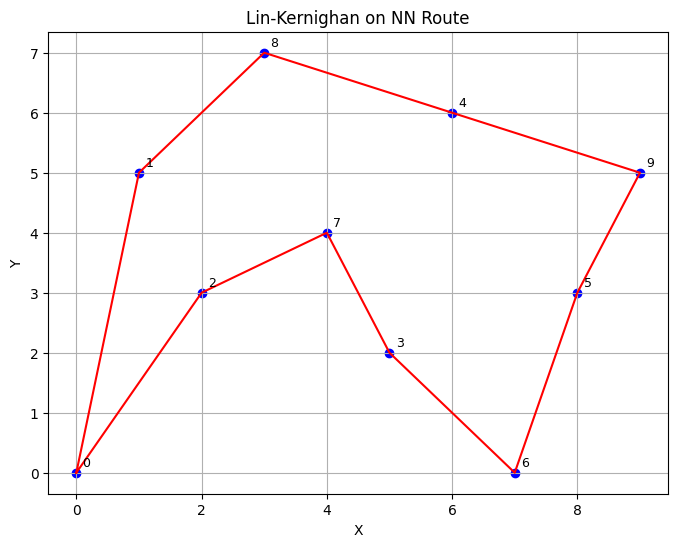

30.556461951553665
Iteração 0: distância inicial = 33.94
Iteração 1: ganho = 2.83, nova distância = 31.11
Iteração 2: ganho = 0.56, nova distância = 30.56


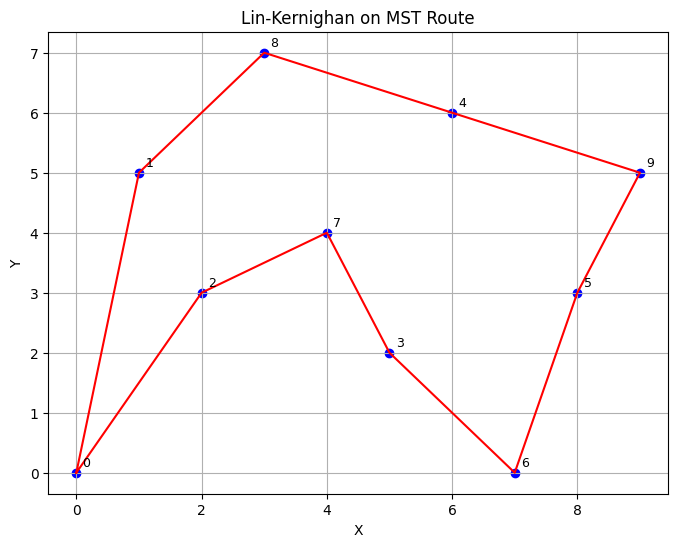

30.556461951553665
Iteração 0: distância inicial = 35.89
Iteração 1: ganho = 2.11, nova distância = 33.78
Iteração 2: ganho = 0.56, nova distância = 33.22


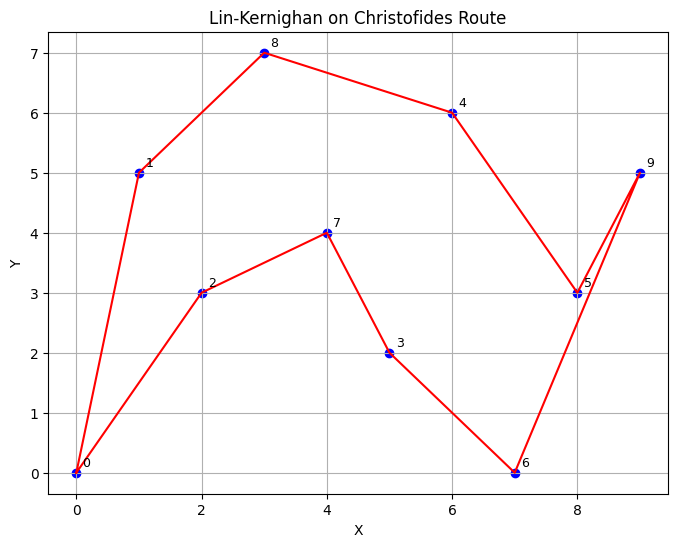

33.2226227138154


In [33]:
nn_route_lk = lin_kernighan(nn_route[:], coords)
plot_tsp(coords, nn_route_lk, title="Lin-Kernighan on NN Route")

mst_route_lk = lin_kernighan(mst_route[:], coords)
plot_tsp(coords, mst_route_lk, title="Lin-Kernighan on MST Route")

christofides_route_lk = lin_kernighan(christofides_route[:], coords)
plot_tsp(coords, christofides_route_lk, title="Lin-Kernighan on Christofides Route")

# Solução PLI com OR-TOOLS

In [34]:
!pip install ortools

In [35]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

def solve_tsp_ortools(coords):
    n = len(coords)
    dist_matrix = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=2).astype(int)
    manager = pywrapcp.RoutingIndexManager(n, 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        return dist_matrix[manager.IndexToNode(from_index)][manager.IndexToNode(to_index)]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        index = routing.Start(0)
        route = []
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        return route
    else:
        return None

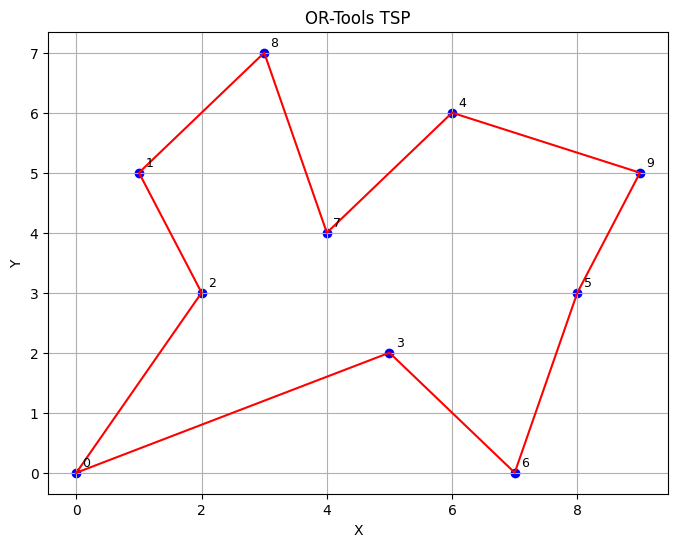

31.43496639234178


In [36]:
ortools_route = solve_tsp_ortools(coords)
plot_tsp(coords, ortools_route, title="OR-Tools TSP")

# Meta-Heurísticas

## Simulated Annealing

In [37]:
import random
import math
def simulated_annealing(coords, temp=10000, cooling_rate=0.995, max_iter=10000):
    n = len(coords)
    current_solution = list(range(n))
    random.shuffle(current_solution)

    def total_distance(route):
        return sum(np.linalg.norm(coords[route[i]] - coords[route[(i+1)%n]]) for i in range(n))

    best = list(current_solution)
    best_cost = total_distance(best)

    for _ in range(max_iter):
        i, j = sorted(random.sample(range(n), 2))
        new_solution = current_solution[:i] + current_solution[i:j+1][::-1] + current_solution[j+1:]
        delta = total_distance(new_solution) - total_distance(current_solution)

        if delta < 0 or random.random() < math.exp(-delta / temp):
            current_solution = new_solution
            if total_distance(current_solution) < best_cost:
                best = current_solution[:]
                best_cost = total_distance(best)

        temp *= cooling_rate
    return best

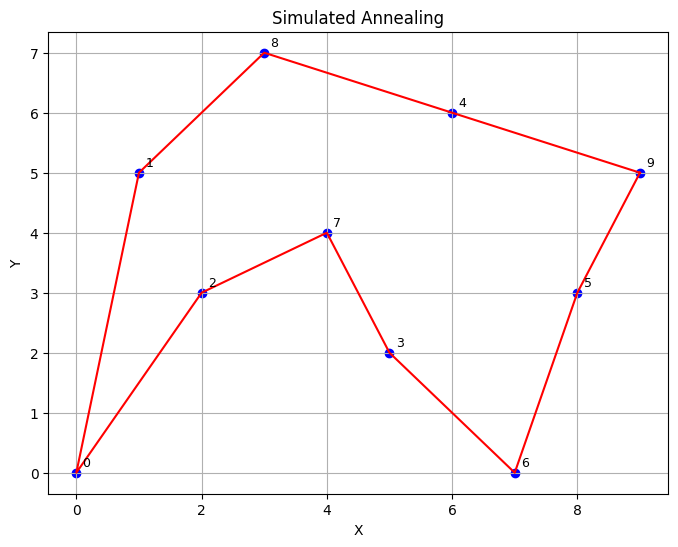

30.556461951553658


In [38]:
sa_route = simulated_annealing(coords)
plot_tsp(coords, sa_route, title="Simulated Annealing")

## Ant Colony Optimization

In [39]:
def ant_colony_optimization(coords, num_ants=10, num_iterations=100, alpha=1.0, beta=5.0, rho=0.5, Q=100):
    n = len(coords)
    dist_matrix = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=2)
    pheromone = np.ones((n, n))
    best_cost = float('inf')
    best_solution = []

    def compute_probability(i, visited):
        probs = np.zeros(n)
        for j in range(n):
            if j not in visited:
                probs[j] = (pheromone[i][j] ** alpha) * ((1 / dist_matrix[i][j]) ** beta)
        total = np.sum(probs)
        if total == 0:
            return np.ones(n) / n
        return probs / total

    for _ in range(num_iterations):
        all_solutions = []
        all_costs = []
        for _ in range(num_ants):
            visited = [random.randint(0, n - 1)]
            while len(visited) < n:
                probs = compute_probability(visited[-1], visited)
                next_city = np.random.choice(range(n), p=probs)
                while next_city in visited:
                    next_city = np.random.choice(range(n), p=probs)
                visited.append(next_city)
            cost = sum(dist_matrix[visited[i]][visited[(i+1)%n]] for i in range(n))
            all_solutions.append(visited)
            all_costs.append(cost)
            if cost < best_cost:
                best_cost = cost
                best_solution = visited[:]

        # Pheromone update
        pheromone *= (1 - rho)
        for i in range(num_ants):
            for j in range(n):
                a, b = all_solutions[i][j], all_solutions[i][(j+1)%n]
                pheromone[a][b] += Q / all_costs[i]
                pheromone[b][a] += Q / all_costs[i]

    return best_solution

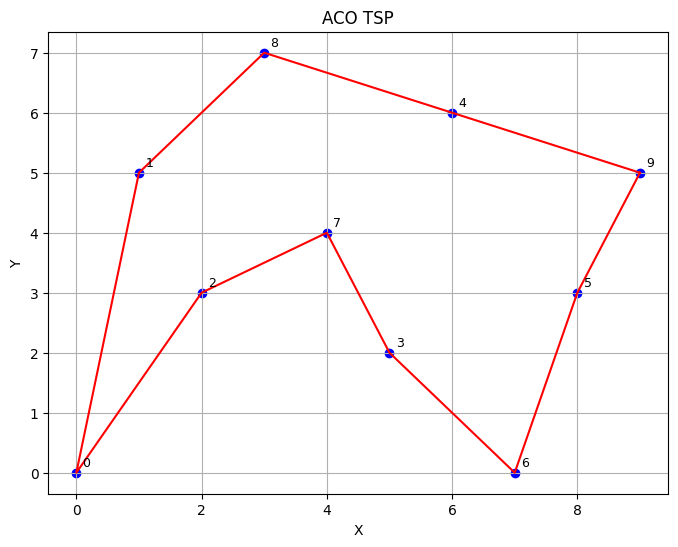

30.556461951553658


In [40]:
aco_route = ant_colony_optimization(coords)
plot_tsp(coords, aco_route, title="ACO TSP")

Iteração 0: distância inicial = 30.56


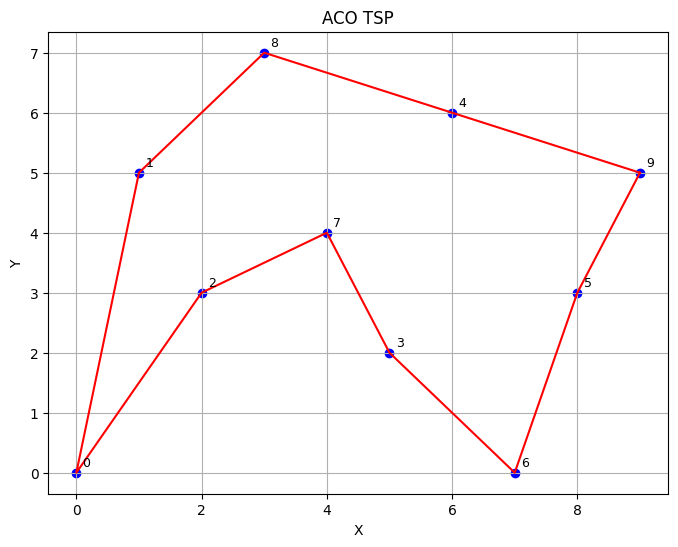

30.556461951553658


In [41]:
aco_route_three = three_opt(aco_route, coords)
plot_tsp(coords, aco_route_three, title="ACO TSP")

# TESTING

In [46]:
def do_heuristics(problem):
  coords = return_coords(problem)
  dist_matrix = compute_distance_matrix(coords)
  a = nearest_neighbor(dist_matrix)
  b = mst_prim_tour(dist_matrix)
  c = christofides_tour(dist_matrix)

  plot_tsp(coords, a)
  plot_tsp(coords, b)
  plot_tsp(coords, c)

def do_metaheuristics(problem):
  coords = return_coords(problem)
  a = simulated_annealing(coords)
  b = ant_colony_optimization(coords)

  plot_tsp(coords, a)
  plot_tsp(coords, b)

def do_solvers(problem):
  coords = return_coords(problem)
  a = solve_tsp_ortools(coords)
  plot_tsp(coords, a)

## BERLIN 52

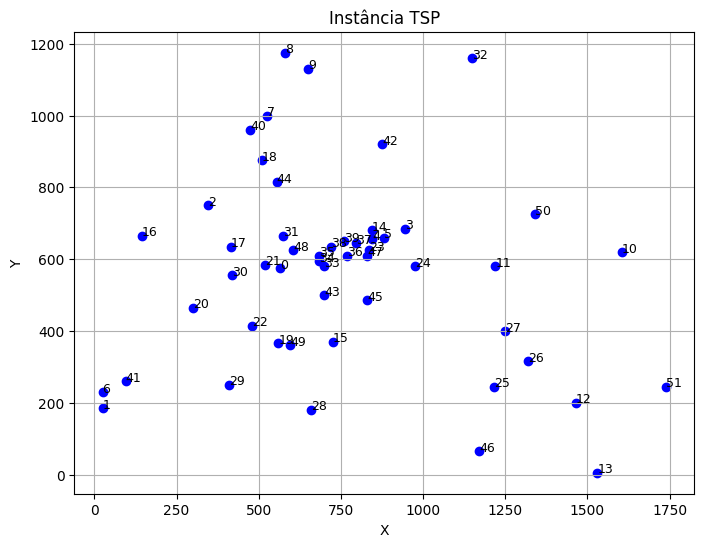

In [47]:
plot_tsp(return_coords(berlin52))

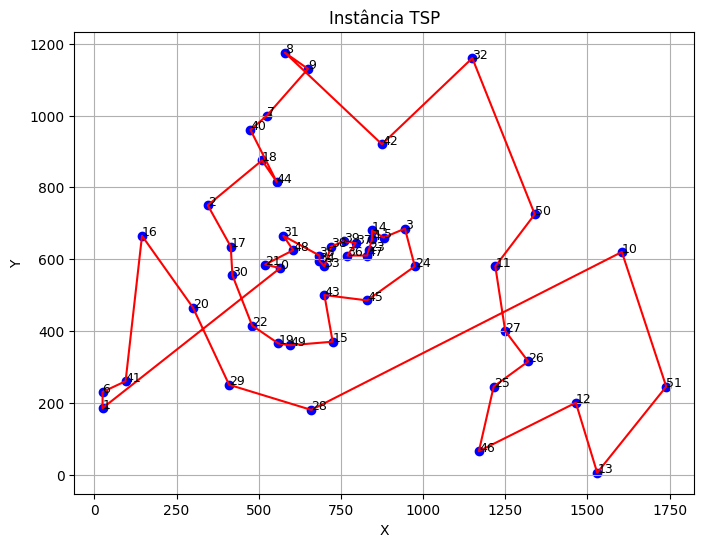

8980.918279329191


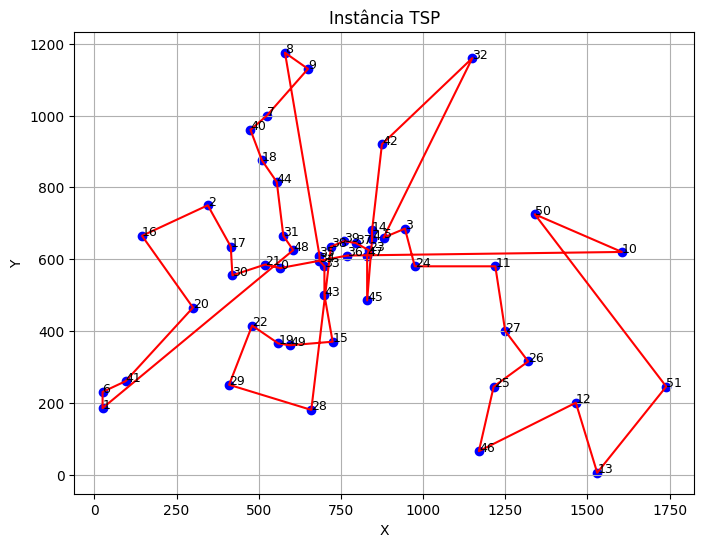

10116.014495510826


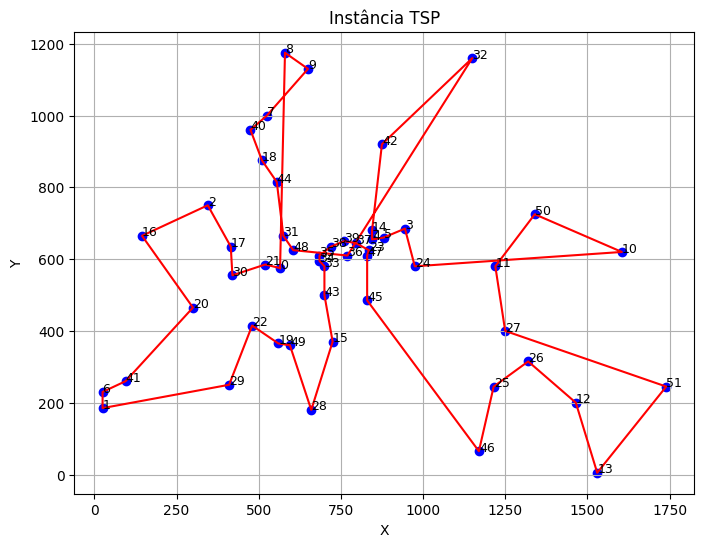

9232.334970324968


In [48]:
do_heuristics(berlin52)

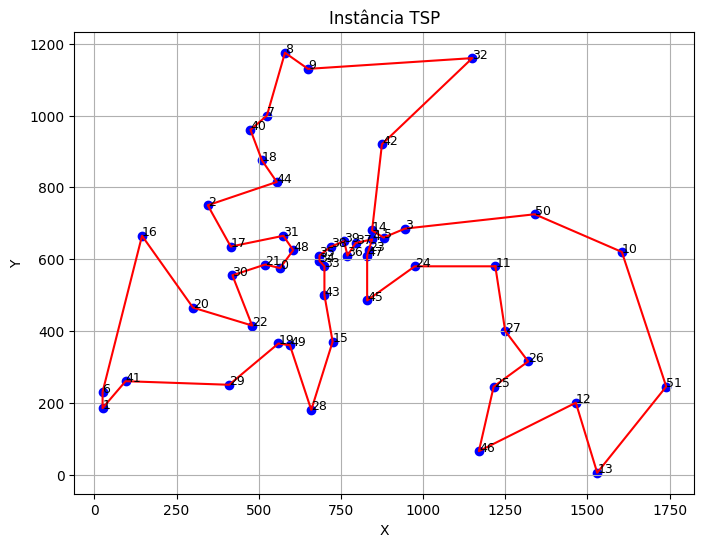

8213.996984216643


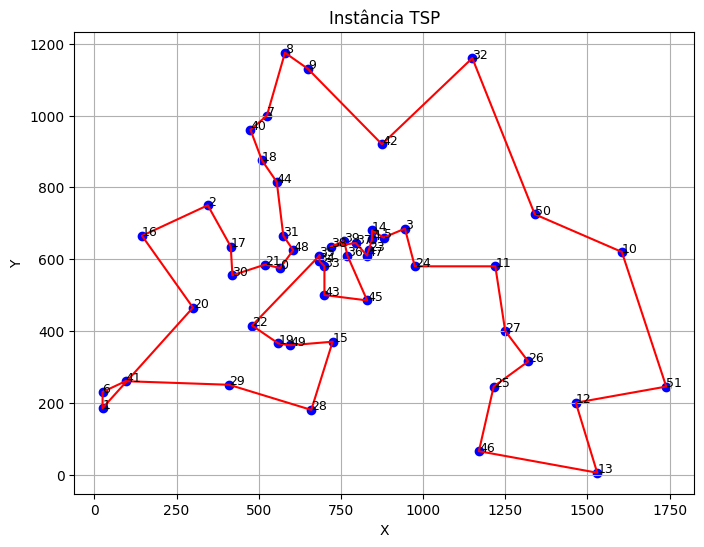

7846.8086178600815


In [49]:
do_metaheuristics(berlin52)

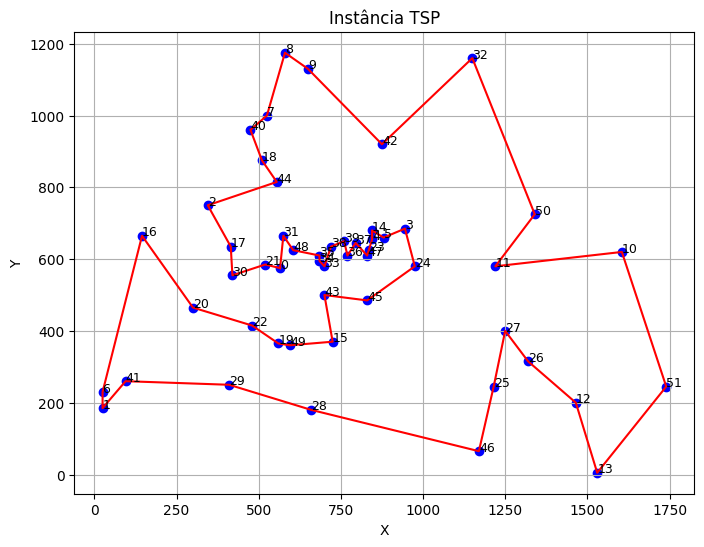

7985.780710294842


In [52]:
do_solvers(berlin52)